# 2D model feature analysis

In [3]:
# Automatically reload modules before code execution
%load_ext autoreload
%autoreload 2

In [6]:
import os
import pickle
import pandas as pd
from PIL import Image
import seaborn as sns

import numpy as np
import torch

import features_lib as flib

In [7]:
import matplotlib.pyplot as plt

# Set plotting style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Display cell and binary mask images (or intensity histograms) for real cells and different betas

### Configuring the appropriate parameters for image display

In [106]:
feats_parent_dir = '/allen/aics/modeling/ic_data/results/integrated_cell/notebook_8/results/feats_alltestcells_7betas_localmean_nostretch/'

intensity_norm   = 0                       # Values = {0, 1}

show_betas       = ['real',  0.010, 0.173, 0.337, 0.500, 0.663, 0.827]  # Values = {'real', 0.010, 0.173, 0.337, 0.500, 0.663, 0.827, 0.99}

sampling         = 'real'                  # Values = {real, kld, norm}
img_type         = 'cell'                  # Value = {'hist', 'cell'}

debug = False

In [107]:
# TODO: Image files are sorted by filename, and not by numerical order

file_suffix = flib.dct_img_type[img_type]

img_paths = []

for col_idx, col_beta in enumerate(show_betas):
    img_paths.append(flib.fnGetFullFilenames(flib.gen_feature_path(feats_parent_dir, intensity_norm, col_beta, sampling), file_suffix))
    
num_cells = len(img_paths[0])
num_betas = len(show_betas)

if (num_cells != 0):

    if (img_type == 'hist'):
        row_factor = 2
        col_factor = 10
    else:
        if (num_betas == 1):
            col_factor = 60
            row_factor = 6
        else:
            col_factor = 10
            row_factor = 4

    objFig, objAxes = plt.subplots(num_cells, num_betas, figsize=(col_factor * num_betas, row_factor * num_cells))

    for row_idx in np.arange(num_cells):

        for col_idx in np.arange(num_betas):

            fn_img = img_paths[col_idx][row_idx]
            arrImg = Image.open(fn_img)

            if (num_betas == 1):
                objAxes[row_idx].imshow(arrImg, cmap='gray')
            else:
                objAxes[row_idx, col_idx].imshow(arrImg, cmap='gray')

        path, basename, ext = flib.fnSplitFullFilename(fn_img)
        if (num_betas == 1):
            objAxes[row_idx].set_ylabel(basename, fontsize=20)
        else:
            objAxes[row_idx, 0].set_ylabel(basename, fontsize=20)

    for col_idx in np.arange(num_betas):
        if (show_betas[col_idx] == 'real'):
            title = f'real cells'
        else:
            title = f'gen cells (norm = {intensity_norm}, beta = {show_betas[col_idx]})'

        if (num_betas > 1):
            objAxes[0, col_idx].set_title(title, fontsize=20)

    #for objAxis in objAxes.flatten():
    #    objAxis.axis('off')

    for objAxis in objAxes.flatten():
        objAxis.xaxis.set_ticks([])
        objAxis.yaxis.set_ticks([])
        objAxis.spines['top'].set_visible(False)
        objAxis.spines['bottom'].set_visible(False)
        objAxis.spines['left'].set_visible(False)
        objAxis.spines['right'].set_visible(False)

else:
    print(f'No cell images found in: {feats_parent_dir}')

No cell images found in: /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/results/feats_caleb_alltestcells_7betas_localmean/


## Print latent space embeddings and cell/nucleus features as a dataframe

In [108]:
# Load the pre-processed and pre-saved cell and nucleus features

all_feats_save_folder = feats_parent_dir

all_feats_fn = 'all_feats.pkl'

#all_feats_save_path = '/allen/aics/modeling/gregj/results/integrated_cell//test_cbvae_beta_ref/results/feats//all_feats.pkl'
all_feats_save_path = os.path.join(all_feats_save_folder, all_feats_fn)

intensity_norms = ['unnormalized', 'normalized']

with open(all_feats_save_path, "rb") as f:
    feature_dict = pickle.load(f)

for i, intensity_norm in enumerate(intensity_norms):

    #features for a specified intensity norm
    feature_dict[i]

    #each sub-dict has real and gen features
    real_feats = feature_dict[i]['real']

    feature_dict[i]['gen']

    #then gen feature dict has features for many betas
    betas = [k for k in feature_dict[i]['gen']]

#     print(betas[0])

    #features_for_the_first_beta = feature_dict[i]['gen'][betas[0]]
    features_for_the_first_beta = feature_dict[i]['gen'][betas[0]]['real']['features']

#     print(features_for_the_first_beta)

    #the real columns and the generated columns (for each beta) are the same
    for columnReal, columnGen in zip(real_feats.columns, features_for_the_first_beta):
        assert columnReal == columnGen

### Filter out the control cells

In [109]:
# Load one of the data splits and get the control cell mask using the ControlMask column. Ideally, we should load the
# data splits that correspond to each model based on the intensity normalization and beta, but it looks like the data
# splits for all the 2D models are identical (to be re-confirmed)

# TODO: Create a mapping to pull the correct data split file based on the intensity normalization and beta

dctDataSplits = torch.load('/allen/aics/modeling/ic_data/data/dctDataSplits_2DModel_test_cbvae_beta_ref_job_298_53492.pth')

dctControlMasks = {}

for strSplit in dctDataSplits:
    dctControlMasks[strSplit] = dctDataSplits[strSplit]['ControlMask']

In [110]:
# Traverse through the nested dictionary (feature_dict) and remove the control cell entries based on the control mask
# Currently, the mask is applied to the rnd_kld and rnd_norm sampled sets so that all the sampled sets have the same
# size, but this is not strictly necessary because those randomly sampled sets do not have control cells

from copy import deepcopy

num_cells = len(feature_dict[0]['real'])

feature_dict_nocontrols = deepcopy(feature_dict)

dfControlMask_Test = dctControlMasks['test']
arrContronMaskIdx_Test = dctControlMasks['test'].index[~dctControlMasks['test']].tolist()

for intensity_norm in feature_dict_nocontrols.keys():
    #print(f'{intensity_norm}')
    for real_or_gen in feature_dict_nocontrols[intensity_norm]:
        #print(f'  {real_or_gen}')
        if (real_or_gen == 'real'):
            feature_dict_nocontrols[intensity_norm][real_or_gen] = feature_dict_nocontrols[intensity_norm][real_or_gen][~dfControlMask_Test]
            #print(f'  {feature_dict_nocontrols[intensity_norm][real_or_gen].shape}')
        else:
            for beta in feature_dict_nocontrols[intensity_norm][real_or_gen]:
                #print(f'    {beta}')
                for sampling in feature_dict_nocontrols[intensity_norm][real_or_gen][beta]:
                    #print(f'      {sampling}')
                    feature_dict_nocontrols[intensity_norm][real_or_gen][beta][sampling]['embeddings'] = feature_dict_nocontrols[intensity_norm][real_or_gen][beta][sampling]['embeddings'][arrContronMaskIdx_Test[0:num_cells], :]
                    #print(f"      {feature_dict_nocontrols[intensity_norm][real_or_gen][beta][sampling]['embeddings'].shape}")
                    feature_dict_nocontrols[intensity_norm][real_or_gen][beta][sampling]['features'] = feature_dict_nocontrols[intensity_norm][real_or_gen][beta][sampling]['features'][~dfControlMask_Test]
                    #print(f"      {feature_dict_nocontrols[intensity_norm][real_or_gen][beta][sampling]['features'].shape}")

### Flatten the features dictionary and output the embeddings and features as dataframes

In [111]:
# Flatten the nested features dictionary into a flat dictionary of 1 level

# Structure of the nested dictionary:
#   norm_intensity{0, 1}/real
#   norm_intensity{0, 1}/gen/beta/real/{embeddings, features}
#                            beta/kld/{embeddings, features}
#                            beta/norm/{embeddings, features}

feature_dict = feature_dict_nocontrols

dct_combined_df_flat = flib.flatten_dict(feature_dict)

# Display the keys in the flattened dictionary
for key in dct_combined_df_flat.keys():
    print(f'{key}')

0_real
0_gen_0.01_real_embeddings
0_gen_0.01_real_features
0_gen_0.01_rnd_kld_embeddings
0_gen_0.01_rnd_kld_features
0_gen_0.01_rnd_norm_embeddings
0_gen_0.01_rnd_norm_features
0_gen_0.173_real_embeddings
0_gen_0.173_real_features
0_gen_0.173_rnd_kld_embeddings
0_gen_0.173_rnd_kld_features
0_gen_0.173_rnd_norm_embeddings
0_gen_0.173_rnd_norm_features
0_gen_0.337_real_embeddings
0_gen_0.337_real_features
0_gen_0.337_rnd_kld_embeddings
0_gen_0.337_rnd_kld_features
0_gen_0.337_rnd_norm_embeddings
0_gen_0.337_rnd_norm_features
0_gen_0.5_real_embeddings
0_gen_0.5_real_features
0_gen_0.5_rnd_kld_embeddings
0_gen_0.5_rnd_kld_features
0_gen_0.5_rnd_norm_embeddings
0_gen_0.5_rnd_norm_features
0_gen_0.663_real_embeddings
0_gen_0.663_real_features
0_gen_0.663_rnd_kld_embeddings
0_gen_0.663_rnd_kld_features
0_gen_0.663_rnd_norm_embeddings
0_gen_0.663_rnd_norm_features
0_gen_0.827_real_embeddings
0_gen_0.827_real_features
0_gen_0.827_rnd_kld_embeddings
0_gen_0.827_rnd_kld_features
0_gen_0.827_rnd_n

### R^2 Analysis between top feature PCs and latent dims (by KLD)

In [124]:
# Specify parameters to use for the R2 analysis

intensity_norm   = 0                       # Values = {0, 1}
show_betas       = ['real',  0.010, 0.173, 0.337, 0.500, 0.663, 0.827]  # Values = {'real', 0.010, 0.173, 0.337, 0.500, 0.663, 0.827, 0.99}
sampling         = 'real'                  # Values = {real, kld, norm}

In [ ]:
feats_to_plot = [
    'cell_shape_volume', 
    'cell_shape_surface_area', 
    'cell_shape_shape_sphericity', 
    
    'cell_inten_intensity_mean', 
    'cell_inten_intensity_median', 
    'cell_inten_intensity_std', 
    'cell_inten_intensity_entropy', 
    
    'dna_shape_volume', 
    'dna_shape_surface_area', 
    'dna_shape_shape_sphericity', 
    
    'dna_inten_intensity_mean', 
    'dna_inten_intensity_median', 
    'dna_inten_intensity_std', 
    'dna_inten_intensity_entropy', 
]

In [125]:
dctR2Analysis = {}

lstModels_2D = []

for beta in show_betas[1:]:
    lstModels_2D.append(f'{intensity_norm}_gen_{beta}_{sampling}')
    
print(f'lstModels_2D = {lstModels_2D}')
print()

# Loop through all the keys in the flattened dictionary and save all the dataframes into a dictionary

fltPCACutoff = 0.9
intKLDThreshold = 0.6
intNumTestCells = 400

dctR2Analysis['Parameters'] = {}
dctR2Analysis['Parameters']['fltPCACutoff'] = fltPCACutoff
dctR2Analysis['Parameters']['intKLDThreshold'] = intKLDThreshold

strKey_real = flib.fnTraverseKey(lstModels_2D[0], 1) + '_real'

if (strKey_real not in dctR2Analysis.keys()):
    dctR2Analysis['FeaturePCA_real'] = {}
    dctR2Analysis['FeaturePCA_real'][strKey_real] = {}
    
    dfFeaturePCs_real, objFeaturePCA_real = flib.fnCalcFeaturePCA(dct_combined_df_flat, strKey_real, argColPrefix='pc_real_', argCols=feats_to_plot)
    intNumTopPCs_real = flib.fnFindTopPCs(objFeaturePCA_real, argCutoff=fltPCACutoff)
    lstTopPCCols_real = list(dfFeaturePCs_real.columns[:intNumTopPCs_real])
    
    dctR2Analysis['FeaturePCA_real'][strKey_real]['objFeaturePCA_real'] = objFeaturePCA_real
    dctR2Analysis['FeaturePCA_real'][strKey_real]['intNumTopPCs_real'] = intNumTopPCs_real
    dctR2Analysis['FeaturePCA_real'][strKey_real]['lstTopPCCols_real'] = lstTopPCCols_real

dctR2Analysis['Models_2D'] = {}

for key in lstModels_2D:

    dctR2Analysis['Models_2D'][key] = {}

    #embeddings = feature_dict[0]['gen'][0.010]['real']['embeddings']
    if (key + '_embeddings' in dct_combined_df_flat.keys()):
        embeddings = dct_combined_df_flat[key + '_embeddings']
        embeddings_shape = embeddings.shape

        embedding_colnames = ['z_' + str(dim) for dim in np.arange(embeddings_shape[1])]

        df_embeddings = pd.DataFrame(embeddings, columns=embedding_colnames)
        dfEmbeddingPCs, objEmbeddingPCA = flib.fnCalcPCA(embeddings, argColPrefix='pc_embed_')

        #df_features = feature_dict[0]['gen'][0.010]['real']['features']
        df_features = dct_combined_df_flat[key + '_features']
        dfFeaturePCs_gen, objFeaturePCA_gen = flib.fnCalcFeaturePCA(dct_combined_df_flat, key + '_features', argColPrefix='pc_gen_', argCols=feats_to_plot)

        df_combined = pd.concat([df_embeddings, df_features, dfEmbeddingPCs, dfFeaturePCs_gen, dfFeaturePCs_real], axis=1)

    else:
        # If we are looking at real cells from the test set, there will only be
        # features but no embeddings since these cells are not generated
        df_combined = pd.concat([dct_combined_df_flat[key], dfFeaturePCs_real], axis=1)

    dctR2Analysis['Models_2D'][key]['df_combined'] = df_combined

    #

    intNumTopPCs_gen = flib.fnFindTopPCs(objFeaturePCA_gen, argCutoff=fltPCACutoff)
    if debug: print(f'intNumTopPCs = {intNumTopPCs_real} (real), {intNumTopPCs_gen} (gen)')

    dctR2Analysis['Models_2D'][key]['intNumTopPCs_gen'] = intNumTopPCs_gen

    # Plot the explained variances of the principal components
    # TODO: Do this for the real features

    if debug:
        plt.figure(figsize=(8, 6))
        plt.suptitle('Explained variance of feature PCAs', fontsize=20)
        objLine_PCA_real = plt.plot(objFeaturePCA_real.explained_variance_ratio_, color='r', linewidth=2, marker='x', markersize=10)
        plt.plot([intNumTopPCs_real] * 2, [0, 1])
        objLine_PCA_gen = plt.plot(objFeaturePCA_gen.explained_variance_ratio_, color='g', linewidth=2, marker='x', markersize=10)
        plt.plot([intNumTopPCs_gen] * 2, [0, 1])
        plt.xlabel('PC', fontsize=16)
        plt.ylabel('Explained variance ratio', fontsize=16)
        _ = plt.xticks(fontsize=12)
        _ = plt.yticks(fontsize=12)

        _ = plt.legend(objLine_PCA_real + objLine_PCA_gen, ['PCA real', 'PCA gen'])

    # Visiualize the embeddings and features dataframe
    #df_combined

    # Save the combined embeddings and features dataframe to a csv file
    #df_combined.to_csv(os.path.join(all_feats_save_folder, f'df_combined_{key}.csv'), index=False)

    # List the shape of the embeddings arrays for all the different combinations
    # of parameters for sanity check
    #for key in dct_combined_df_flat.keys():
    #    if ('_embeddings' in key):
    #        print(f'{key}: {dct_combined_df_flat[key].shape}')

    #
    corr_method = 'pearson'  # spearman/pearson

    mu_cols = [c for c in df_combined.columns if c.startswith("z_")]
    mu_pc_cols = [c for c in df_combined.columns if c.startswith("pc_embed_")]
    feat_cols = [c for c in df_combined.columns if (c.startswith("dna_") or (c.startswith("cell_") and c != "cell_idx"))]
    pc_real_cols = [c for c in df_combined.columns if c.startswith("pc_real_")]
    pc_gen_cols = [c for c in df_combined.columns if c.startswith("pc_gen_")]

    lstTopPCCols_gen = pc_gen_cols[:intNumTopPCs_gen]
    if debug:
        print(f'lstTopPCCols_real = {lstTopPCCols_real}')
        print(f'lstTopPCCols_gen = {lstTopPCCols_gen}')

    dctR2Analysis['Models_2D'][key]['lstTopPCCols_gen'] = lstTopPCCols_gen

    #
    dfSortedKLDs = df_combined[mu_cols].abs().mean().sort_values(ascending=False)
    lstTopKLDCols = list(dfSortedKLDs[dfSortedKLDs > intKLDThreshold].index)

    intNumTopKLDs = len(lstTopKLDCols)
    if debug:
        print(f'intNumTopKLDs = {intNumTopKLDs}')
        #print(f'lstTopKLDCols = {lstTopKLDCols}')
        print()

    dctR2Analysis['Models_2D'][key]['dfSortedKLDs'] = dfSortedKLDs
    dctR2Analysis['Models_2D'][key]['lstTopKLDCols'] = lstTopKLDCols

    if debug:
        plt.figure(figsize=(8, 6))
        plt.suptitle('Latent dims ranked by KLDs', fontsize=20)

        _ = plt.plot(dfSortedKLDs.to_numpy())
        plt.plot([0, len(dfSortedKLDs)], [intKLDThreshold] * 2)

        plt.xlabel('Ranked latent dim', fontsize=16)
        plt.ylabel('KLD', fontsize=16)
        _ = plt.xticks(fontsize=12)
        _ = plt.yticks(fontsize=12)

    # R^2 Analysis between top PCs and latent dims (by KLD)

    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score

    print(f'key = {key}, intNumTopKLDs = {intNumTopKLDs}')

    dctR2Analysis['Models_2D'][key]['LinRegrModels'] = {}
        
    for intPC in np.arange(intNumTopPCs_real):
        strPC = lstTopPCCols_real[intPC]
        if debug: print(f'strPC = {strPC}')

        dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC] = {}

        X = df_combined[lstTopKLDCols].to_numpy()
        y = df_combined[lstTopPCCols_real[intPC]].to_numpy()

        # Split the data into training/testing sets
        X_train = X[:-intNumTestCells]
        X_test = X[-intNumTestCells:]
        #print(f'{X_train.shape}, {X_test.shape}')

        # Split the targets into training/testing sets
        y_train = y[:-intNumTestCells]
        y_test = y[-intNumTestCells:]

        # Create linear regression object
        objLinRegr = linear_model.LinearRegression()

        # Train the model using the training sets
        objLinRegr.fit(X, y)

        # Make predictions using the testing set
        y_pred = objLinRegr.predict(X_test)

        arrCoeffs = objLinRegr.coef_
        fltMSE = mean_squared_error(y_test, y_pred)
        fltR2Score = r2_score(y_test, y_pred)

        # The coefficients
        #print(f'  Coefficients: {arrCoeffs}')
        # The mean squared error
        if debug: print(f'  Mean squared error: {fltMSE:.2f}')
        # The coefficient of determination: 1 is perfect prediction
        if debug: print(f'  Coefficient of determination: {fltR2Score:.2f}')

        dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['Coeffs'] = arrCoeffs
        dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['MSE'] = fltMSE
        dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['R2'] = fltR2Score

lstModels_2D = ['0_gen_0.01_real', '0_gen_0.173_real', '0_gen_0.337_real', '0_gen_0.5_real', '0_gen_0.663_real', '0_gen_0.827_real']

key = 0_gen_0.01_real, intNumTopKLDs = 169
key = 0_gen_0.173_real, intNumTopKLDs = 40
key = 0_gen_0.337_real, intNumTopKLDs = 23
key = 0_gen_0.5_real, intNumTopKLDs = 13
key = 0_gen_0.663_real, intNumTopKLDs = 7
key = 0_gen_0.827_real, intNumTopKLDs = 3


## Plot the results of the R^2 analysis as they appear in the paper

In [126]:
figsize = (8, 6)
titlesize = 20
labelsize = 20
ticksize = 14
legendsize = 12

beta = 0.01, # top latent dims = 169
beta = 0.173, # top latent dims = 40
beta = 0.337, # top latent dims = 23
beta = 0.5, # top latent dims = 13
beta = 0.663, # top latent dims = 7
beta = 0.827, # top latent dims = 3


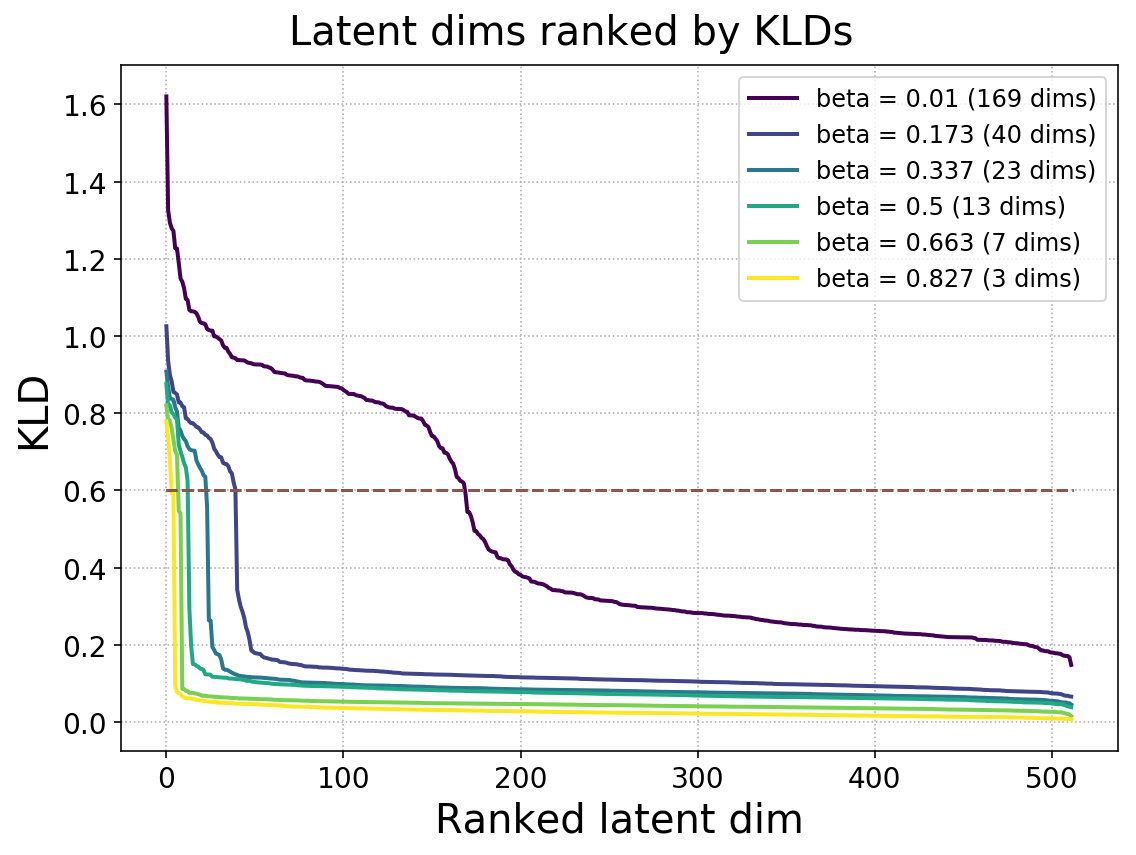

In [127]:
plt.figure(figsize=figsize)
plt.suptitle('Latent dims ranked by KLDs', fontsize=titlesize)

intKLDThreshold = dctR2Analysis['Parameters']['intKLDThreshold']

lstLineObjs = []
lstModels_2D = []

lstColors = plt.get_cmap('viridis')(np.linspace(0, 1, len(dctR2Analysis['Models_2D'].keys())))

for intIdx, strModel_2D in enumerate(dctR2Analysis['Models_2D'].keys()):
    strBeta = flib.fnExtractSubkey(strModel_2D, 2)
    intNumTopKLDs = len(dctR2Analysis['Models_2D'][strModel_2D]['lstTopKLDCols'])
    lstModels_2D.append(f'beta = {strBeta} ({intNumTopKLDs} dims)')
    print(f'beta = {strBeta}, # top latent dims = {intNumTopKLDs}')
    
    dfSortedKLDs = dctR2Analysis['Models_2D'][strModel_2D]['dfSortedKLDs']
    objLine_SortedKLDs = plt.plot(dfSortedKLDs.to_numpy(), linewidth=2, color=lstColors[intIdx, :])
    lstLineObjs = lstLineObjs + objLine_SortedKLDs
    plt.plot([0, len(dfSortedKLDs)], [intKLDThreshold] * 2, '--')

plt.xlabel('Ranked latent dim', fontsize=labelsize)
plt.ylabel('KLD', fontsize=labelsize)

_ = plt.xticks(fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)

_ = plt.legend(lstLineObjs, lstModels_2D, prop={'size':legendsize})
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.subplots_adjust(top=0.92)

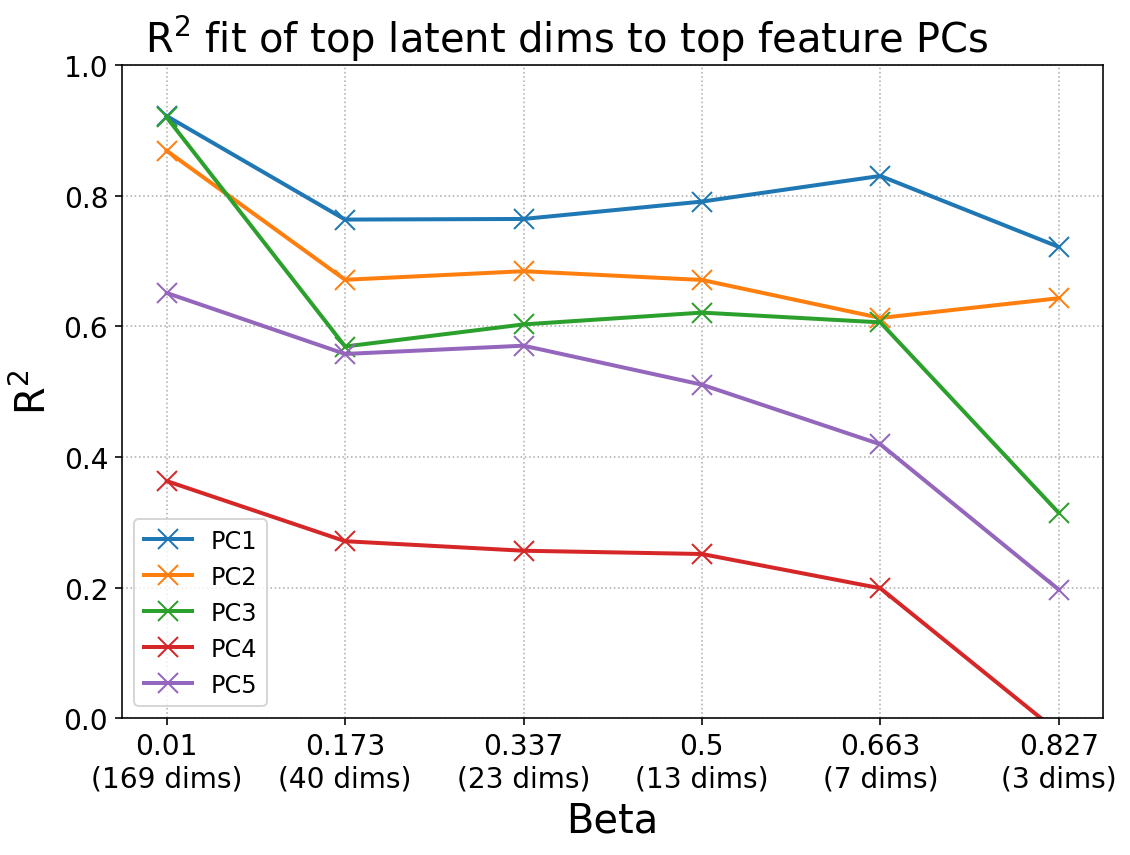

In [128]:
lstModels_2D = list(dctR2Analysis['Models_2D'].keys())
lstModels_LinRegr = list(dctR2Analysis['Models_2D'][lstModels_2D[0]]['LinRegrModels'].keys())

intNumModels_2D = len(lstModels_2D)
intNumModels_LinRegr = len(lstModels_LinRegr)

arrR2s = np.zeros((intNumModels_2D, intNumModels_LinRegr))

for intModel_2D, key in enumerate(lstModels_2D):
    if debug: print(f'{key}:')
    for intModel_LinRegr, strPC in enumerate(dctR2Analysis['Models_2D'][key]['LinRegrModels'].keys()):
        if debug: print(f"  {strPC}:  MSE = {dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['MSE']:.2f}, R2 = {dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['R2']:.2f}")
        arrR2s[intModel_2D, intModel_LinRegr] = dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['R2']
        
if debug: print()

plt.figure(figsize=figsize)
plt.suptitle('$\mathregular{R^2}$ fit of top latent dims to top feature PCs', fontsize=titlesize)

lstLineObjs = []

for intModel_LinRegr, strModel_LinRegr in enumerate(lstModels_LinRegr):
    objLine_LinRegrModel_R2s = plt.plot(arrR2s[:, intModel_LinRegr], linewidth=2, marker='x', markersize=10)
    lstLineObjs = lstLineObjs + objLine_LinRegrModel_R2s
    
plt.xlabel('Beta', fontsize=labelsize)
plt.ylabel('$\mathregular{R^2}$', fontsize=labelsize)

lstBetas = []

for strModel_2D in lstModels_2D:
    intNumTopKLDs = len(dctR2Analysis['Models_2D'][strModel_2D]['lstTopKLDCols'])
    lstBetas.append(f'{flib.fnExtractSubkey(strModel_2D, 2)}\n({intNumTopKLDs} dims)')
    
_ = plt.xticks(np.arange(len(lstBetas)), lstBetas, fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)
plt.ylim((0, 1.0))

_ = plt.legend(lstLineObjs, flib.fnGenPrettyPCNames(lstModels_LinRegr), prop={'size':legendsize})
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.subplots_adjust(top=0.92)

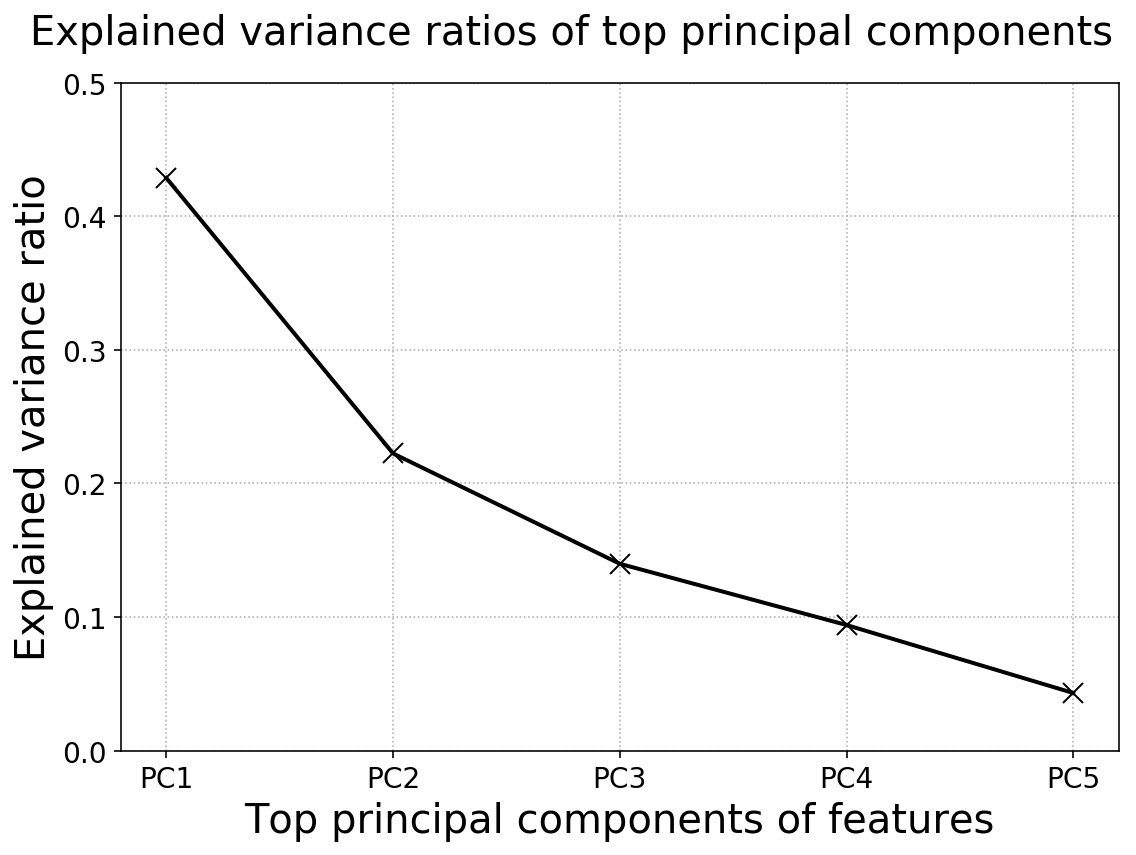

In [129]:
lstKeys_PCA_real = dctR2Analysis['FeaturePCA_real'].keys()

plt.figure(figsize=figsize)
plt.suptitle('Explained variance ratios of top principal components', fontsize=titlesize)

lstLineObjs = []

for strKey_PCA_real in lstKeys_PCA_real:
    intNumTopPCs_real = dctR2Analysis['FeaturePCA_real'][strKey_PCA_real]['intNumTopPCs_real']
    objFeaturePCA_real = dctR2Analysis['FeaturePCA_real'][strKey_PCA_real]['objFeaturePCA_real']
    lstTopPCCols_real = dctR2Analysis['FeaturePCA_real'][strKey_PCA_real]['lstTopPCCols_real']

    # Print the total explained variance for the top PCs
    flib.fnFindTopPCs(objFeaturePCA_real, argCutoff=fltPCACutoff)
    
    objLine_ExplainedVarRatios_real = plt.plot(objFeaturePCA_real.explained_variance_ratio_[:intNumTopPCs_real], color='k', linewidth=2, marker='x', markersize=10)
    lstLineObjs = lstLineObjs + objLine_ExplainedVarRatios_real
        
plt.xlabel('Top principal components of features', fontsize=labelsize)
plt.ylabel('Explained variance ratio', fontsize=labelsize)

_ = plt.xticks(np.arange(len(lstTopPCCols_real)), flib.fnGenPrettyPCNames(lstTopPCCols_real), fontsize=ticksize, rotation=0)
_ = plt.yticks(fontsize=ticksize)
plt.ylim((0, 0.5))

#_ = plt.legend(lstLineObjs, lstKeys_PCA_real, prop={'size':legendsize})
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.subplots_adjust(top=0.90)

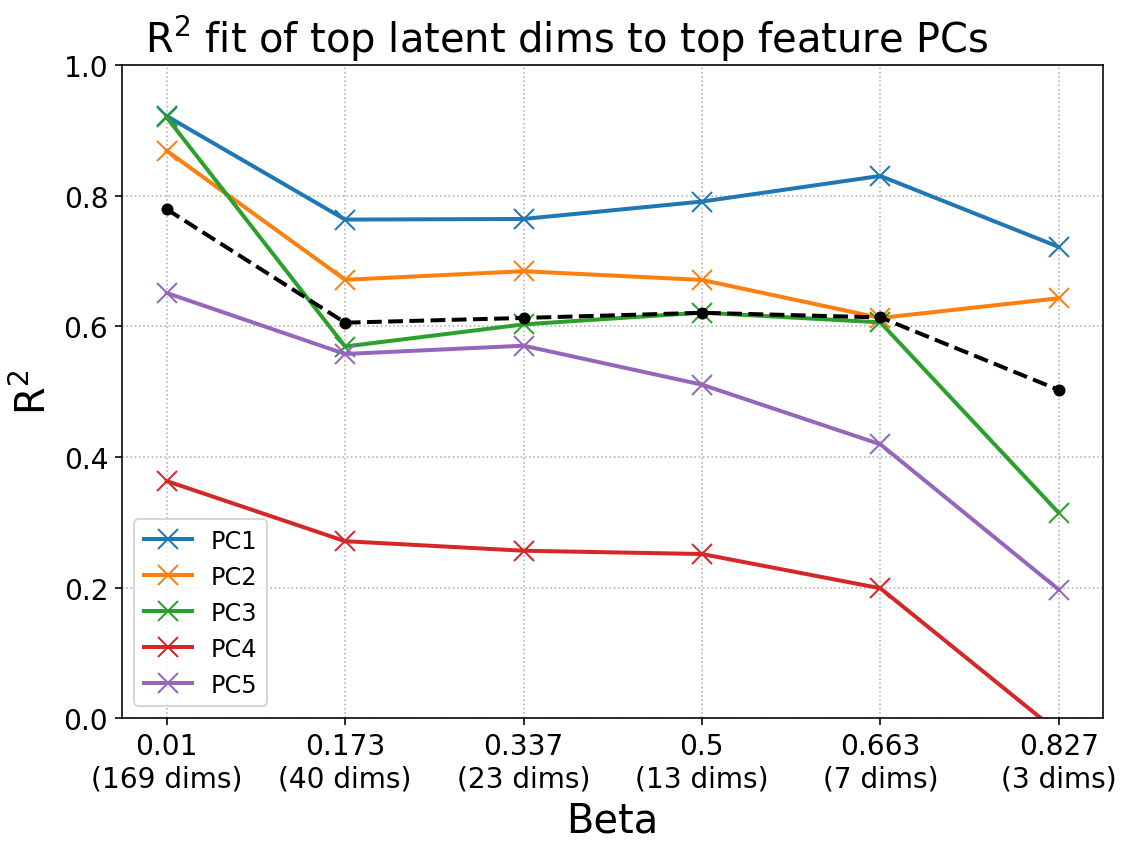

In [130]:
lstModels_2D = list(dctR2Analysis['Models_2D'].keys())
lstModels_LinRegr = list(dctR2Analysis['Models_2D'][lstModels_2D[0]]['LinRegrModels'].keys())

intNumModels_2D = len(lstModels_2D)
intNumModels_LinRegr = len(lstModels_LinRegr)

arrR2s = np.zeros((intNumModels_2D, intNumModels_LinRegr))

for intModel_2D, key in enumerate(lstModels_2D):
    if debug: print(f'{key}:')
    for intModel_LinRegr, strPC in enumerate(dctR2Analysis['Models_2D'][key]['LinRegrModels'].keys()):
        if debug: print(f"  {strPC}:  MSE = {dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['MSE']:.2f}, R2 = {dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['R2']:.2f}")
        arrR2s[intModel_2D, intModel_LinRegr] = dctR2Analysis['Models_2D'][key]['LinRegrModels'][strPC]['R2']
        
if debug: print()

plt.figure(figsize=figsize)
plt.suptitle('$\mathregular{R^2}$ fit of top latent dims to top feature PCs', fontsize=titlesize)

lstLineObjs = []

for intModel_LinRegr, strModel_LinRegr in enumerate(lstModels_LinRegr):
    objLine_LinRegrModel_R2s = plt.plot(arrR2s[:, intModel_LinRegr], linewidth=2, marker='x', markersize=10)
    lstLineObjs = lstLineObjs + objLine_LinRegrModel_R2s
    
arrExpVar = objFeaturePCA_real.explained_variance_ratio_[:intNumTopPCs_real]
arrWeightedR2s = np.matmul(arrR2s, arrExpVar.T)
objLine_WeightedR2s = plt.plot(arrWeightedR2s, linestyle='--', linewidth=2, color='k', marker='o', markersize=5)
if debug: print(f'Weighted R2s = {arrWeightedR2s}')

plt.xlabel('Beta', fontsize=labelsize)
plt.ylabel('$\mathregular{R^2}$', fontsize=labelsize)

lstBetas = []

for strModel_2D in lstModels_2D:
    intNumTopKLDs = len(dctR2Analysis['Models_2D'][strModel_2D]['lstTopKLDCols'])
    lstBetas.append(f'{flib.fnExtractSubkey(strModel_2D, 2)}\n({intNumTopKLDs} dims)')
    
_ = plt.xticks(np.arange(len(lstBetas)), lstBetas, fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)
plt.ylim((0, 1.0))

_ = plt.legend(lstLineObjs, flib.fnGenPrettyPCNames(lstModels_LinRegr), prop={'size':legendsize})
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.subplots_adjust(top=0.92)

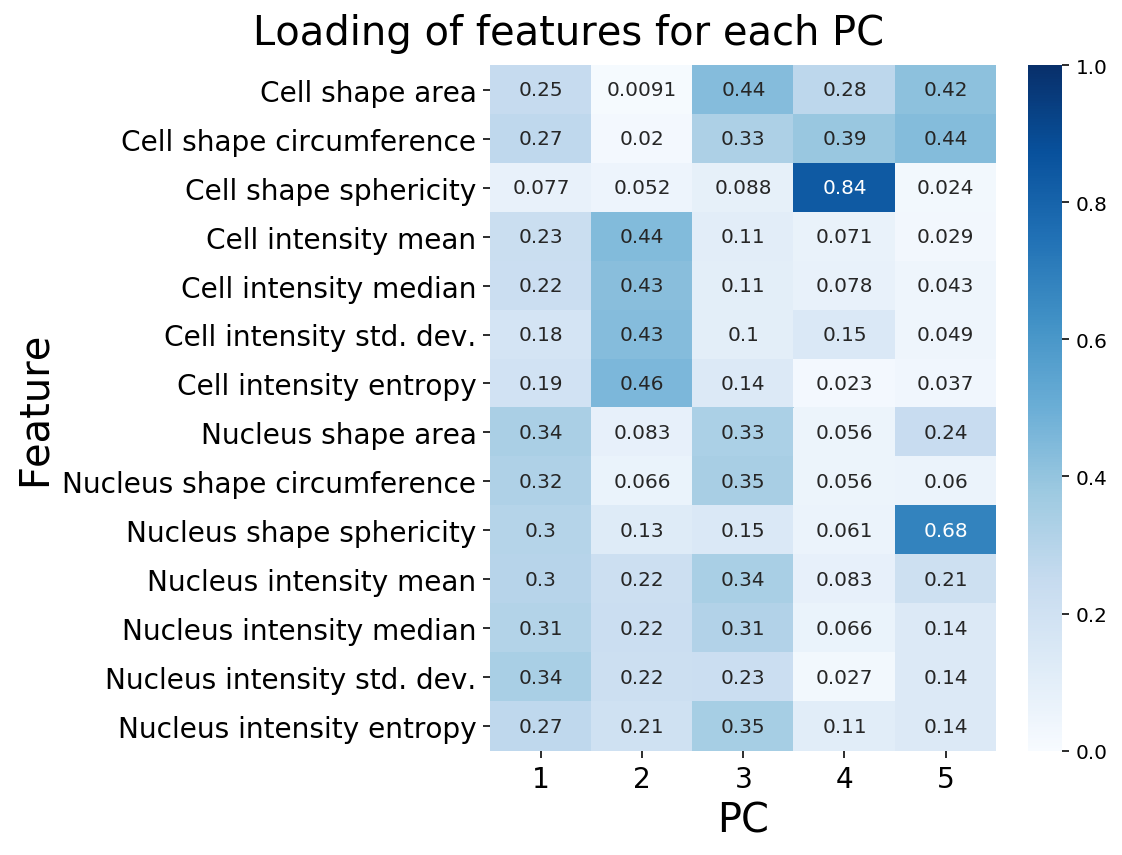

In [131]:
plt.figure(figsize=figsize)
plt.suptitle('Loading of features for each PC', fontsize=titlesize)

dfFeaturePCA_real_components = pd.DataFrame(
    data=dctR2Analysis['FeaturePCA_real']['0_real']['objFeaturePCA_real'].components_[0:intNumTopPCs_real, :], 
    columns=flib.fnGenPrettyFeatureNames(feats_to_plot), 
    index=np.arange(1, intNumTopPCs_real + 1), 
)

g = sns.heatmap(
    dfFeaturePCA_real_components.T.abs(),
    #row_cluster=False,
    #figsize=(6,6),
    annot=True, 
    cmap="Blues",
    vmin=0,
    #center=0,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    #ax=objAxes_heatmap[0]
);

plt.xlabel('PC', fontsize=labelsize)
plt.ylabel('Feature', fontsize=labelsize)

_ = plt.xticks(fontsize=ticksize)
_ = plt.yticks(fontsize=ticksize)

plt.tight_layout()
plt.subplots_adjust(top=0.92)